# Standard Regression (BQML)

In [1]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

## 0) Dependencies

In [2]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = '' #add proj name and dataset

In [ ]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = project_name #update project name 
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


# data processing libraries
import numpy as np
import pandas as pd


# modeling and metrics
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

!pip install relativeImp
from relativeImp import relativeImp


# visutalization
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Import dataset

Import the data using the bigquery magics (%% command). 
Pulls all of the data from the cleaned data table and stores into a dataframe "df"

In [4]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [5]:
%%bigquery df
SELECT *
FROM `.RBA_demo.cleaned_data_2_23_22`; #update project name

In [6]:
df.columns

Index(['x5Lag0Alpha1_0Decay1_0', 'x6Lag0Alpha0_6Decay1_0',
       'x10Lag0Alpha1_0Decay1_0', 'x12Lag0Alpha1_0Decay1_0',
       'x13Lag0Alpha0_8Decay1_0', 'x16Lag0Alpha1_0Decay0_9',
       'x17Lag1Alpha0_8Decay0_7', 'x26Lag0Alpha1_0Decay0_9',
       'x27Lag5Alpha1_0Decay1_0', 'x28Lag3Alpha0_7Decay0_6',
       'x29Lag0Alpha0_6Decay1_0', 'x30Lag4Alpha1_0Decay1_0',
       'x31Lag5Alpha1_0Decay1_0', 'x32Lag0Alpha0_6Decay0_9',
       'x33Lag0Alpha1_0Decay1_0', 'x34Lag0Alpha1_0Decay1_0',
       'x35Lag5Alpha0_6Decay1_0', 'x36Lag0Alpha0_7Decay0_8',
       'x37Lag5Alpha0_6Decay1_0', 'x38Lag3Alpha0_6Decay0_7',
       'x39Lag0Alpha0_9Decay1_0', 'x40Lag4Alpha0_6Decay0_7',
       'x41Lag0Alpha1_0Decay1_0', 'x42Lag0Alpha0_7Decay1_0',
       'x44Lag0Alpha0_6Decay0_8', 'x45Lag0Alpha0_8Decay1_0',
       'x46Lag0Alpha0_6Decay0_9', 'Is_Monday', 'Is_Q2Q3', 'y1'],
      dtype='object')

In [ ]:
df.describe()

## 2) Run the RBA Model in BQML

In [8]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [9]:
%%bigquery
CREATE OR REPLACE MODEL `.RBA_demo.RBA_model`  #update project name
OPTIONS (model_type='linear_reg',
         input_label_cols = ['y1'])
AS SELECT *
    FROM `.RBA_demo.cleaned_data`; #update project name

""


### 2.1) Print the model coefficient results

Call the model coefficient weights from the model and save to a dataframe "model_coefficients_results".

The standardize parameter is an optional parameter that determines whether the model  weights should be standardized to assume that all features have a mean of zero and a  standard deviation of one. Standardizing the weights allows the absolute magnitude of the weights to be compared to each other.


In [10]:
%%bigquery model_coefficients_results
SELECT
  *
FROM
  ML.WEIGHTS(MODEL `.RBA_demo.RBA_model`,
    STRUCT(true AS standardize)) #update project name

In [ ]:
model_coefficients_results

### 2.2) Print the model evaluation metrics

In [12]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Call the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".

For linear regression models The ML.EVALUATE function returns: mean absolute error,mean squared erorr, mean squared log error, median absolute error, r-squared, and explained variance metrics.

In [13]:
%%bigquery evaluation_metrics
SELECT *
FROM ML.EVALUATE(MODEL `.RBA_demo.RBA_model`) #update project name

In [14]:
evaluation_metrics

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,155.211908,38445.140141,0.007091,130.667335,0.82721,0.827298


## 3) Calculate contribution of each digital media tactic on conversions

Use the [relativeImp package](https://pypi.org/project/relativeImp/)
to conduct key driver analysis and generate relative importance values by feature in the model.

The relativeImp function produces a raw relative importance and a normalized relative importance value. 
- Raw relative importance sums to the r-squared of the linear model.
- Normalized relative importance is scaled to sum to 1


In [15]:
conversions = 'y1'
tactics = df[df.columns[df.columns != conversions]].columns.to_list()
relative_importance_results = relativeImp(df, 
                                          outcomeName = conversions, 
                                          driverNames = tactics)

In [16]:
relative_importance_results

,driver,rawRelaImpt,normRelaImpt
0,x5Lag0Alpha1_0Decay1_0,0.005688,0.682658
1,x6Lag0Alpha0_6Decay1_0,0.100825,12.101356
2,x10Lag0Alpha1_0Decay1_0,0.243987,29.284106
3,x12Lag0Alpha1_0Decay1_0,0.152005,18.244205
4,x13Lag0Alpha0_8Decay1_0,0.011614,1.393900
5,x16Lag0Alpha1_0Decay0_9,0.008942,1.073238
6,x17Lag1Alpha0_8Decay0_7,0.006391,0.767125
7,x26Lag0Alpha1_0Decay0_9,0.004350,0.522101
8,x27Lag5Alpha1_0Decay1_0,0.027893,3.347807
9,x28Lag3Alpha0_7Decay0_6,0.016088,1.930937


## 4) Validate Linear Regression Model Assumptions

For any statistical model it is important to validate model assumptions.
With RBA, we validate the standard linear model assumptions of:

  - Linearity
  - Normality of errors
  - Absence of multicollinearity
  - Homoscedasticity
  - Absence of autocorrelation of residuals



If any of the model assumptions fail, a different model specification, as well as re-examination of the data should be considered

Incorrect model use can lead to unreliable results

### 4.1) Generate model predictions and residuals

In [17]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Select the predicted conversions (y1) of the model and actual conversions from the data (y1) using the ML.PREDICT function

In [18]:
%%bigquery model_predictions
SELECT
  *
FROM
  ML.PREDICT(MODEL `.RBA_demo.RBA_model`, #update project name
    (
    SELECT
        *
    FROM
      `.RBA_demo.cleaned_data`)); #update project name

Calculate model residuals as the difference from predicted y1 values and actual y1 values


In [19]:
model_predictions['residuals'] = model_predictions.predicted_y1 - model_predictions.y1

### 4.2) Linearity

Visually inspect linearity between target variable (y1) and predictions

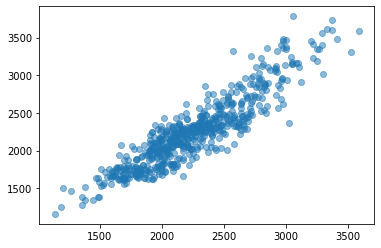

In [20]:
plt.plot(model_predictions.predicted_y1,model_predictions.y1,'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

Visually inspect the residuals to confirm normality

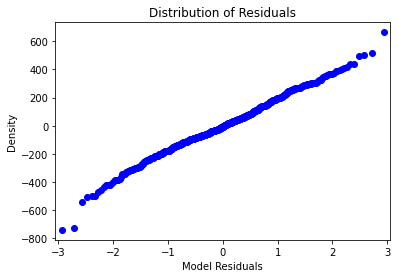

In [21]:
fig = sm.qqplot(model_predictions.residuals)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

### 4.4) Absence of Multicollinearity

Multicollinearity was checked and handled during data pre-processing stage.

### 4.5) Homoscedasticity


Visually inspect residuals to confirm constant variance

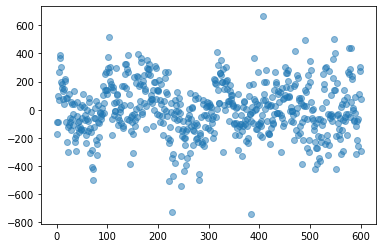

In [22]:
plt.plot(model_predictions.residuals,'o',alpha=0.5)
plt.show()

### 4.6) Absence of Autocorrelation of the residuals

The Durbin Watson test is a statistical test for detecting autocorrelation of the model residuals

In [ ]:
dw = durbin_watson(model_predictions.residuals)
print('Durbin-Watson',dw)

In [ ]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')
